In [1]:
!pip install arviz
!pip install tensorflow tensorflow-probability
!pip install pymc

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow as tf
import arviz as az
import matplotlib.pyplot as plt

In [3]:
TodaysData_Country = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv')
cleaned_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv')
florida_data = cleaned_data[(cleaned_data['Country_Region'] == 'US') & (cleaned_data['Province_State'] == 'Florida')]
print(florida_data.head(4))
florida_data['Last_Update'] = pd.to_datetime(florida_data['Last_Update'])

C:\Users\gesua\AppData\Local\Temp\ipykernel_41640\3228813242.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv')
C:\Users\gesua\AppData\Local\Temp\ipykernel_41640\3228813242.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  florida_data['Last_Update'] = pd.to_datetime(florida_data['Last_Update'])
C:\Users\gesua\AppData\Local\Temp\ipykernel_41640\3228813242.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  florida_data['Last_Update'] =

       Country_Region Last_Update  Confirmed  Deaths  Recovered  Active  \
242316             US     1/22/20          0       0        NaN     NaN   
242317             US     1/23/20          0       0        NaN     NaN   
242318             US     1/24/20          0       0        NaN     NaN   
242319             US     1/25/20          0       0        NaN     NaN   

        Delta_Confirmed  Delta_Recovered  Incident_Rate  People_Tested  \
242316              0.0              NaN            0.0            NaN   
242317              0.0              NaN            0.0            NaN   
242318              0.0              NaN            0.0            NaN   
242319              0.0              NaN            0.0            NaN   

        People_Hospitalized Province_State  FIPS       UID iso3  \
242316                  NaN        Florida  12.0  84000012  USA   
242317                  NaN        Florida  12.0  84000012  USA   
242318                  NaN        Florida  12.0  84

C:\Users\gesua\AppData\Local\Temp\ipykernel_41640\2741280175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  florida_data['Last_Update'] = pd.to_datetime(florida_data['Last_Update'])
C:\Users\gesua\AppData\Local\Temp\ipykernel_41640\2741280175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  florida_data.fillna(0, inplace=True)  # or use other filling methods as needed


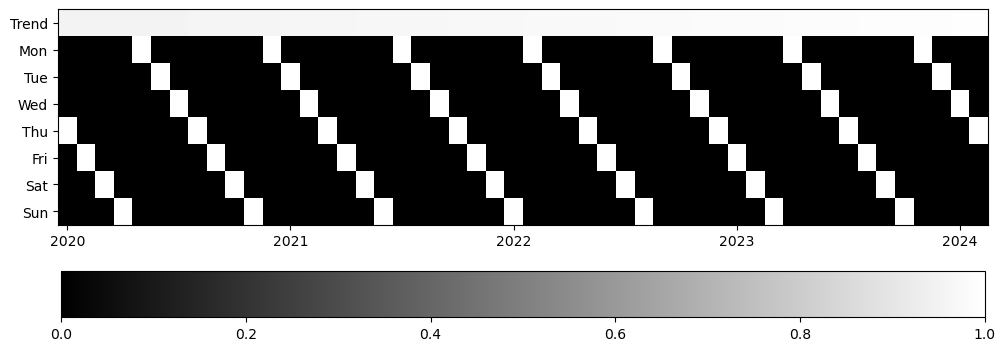

In [4]:
florida_data['Last_Update'] = pd.to_datetime(florida_data['Last_Update'])
florida_data.set_index('Last_Update', inplace=True)
florida_data.fillna(0, inplace=True)

trend_all = np.linspace(0., 1., len(florida_data))[..., None]
trend_all = trend_all.astype(np.float32)
num_forecast_steps = 7
trend = trend_all[:-num_forecast_steps, :]

seasonality_all = pd.get_dummies(florida_data.index.dayofweek).values.astype(np.float32)
seasonality = seasonality_all[:-num_forecast_steps, :]

# Visualize
_, ax = plt.subplots(figsize=(12, 4))
X_subset = np.concatenate([trend, seasonality], axis=-1)[-50:]
im = ax.imshow(X_subset.T, aspect='auto', cmap='gray', interpolation='none')
plt.colorbar(im, ax=ax, orientation='horizontal')
ax.set_xticks([0, 12, 24, 36, 48])
ax.set_xticklabels(['2020', '2021', '2022', '2023', '2024'])
ax.set_yticks(range(8))
ax.set_yticklabels(['Trend'] + ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

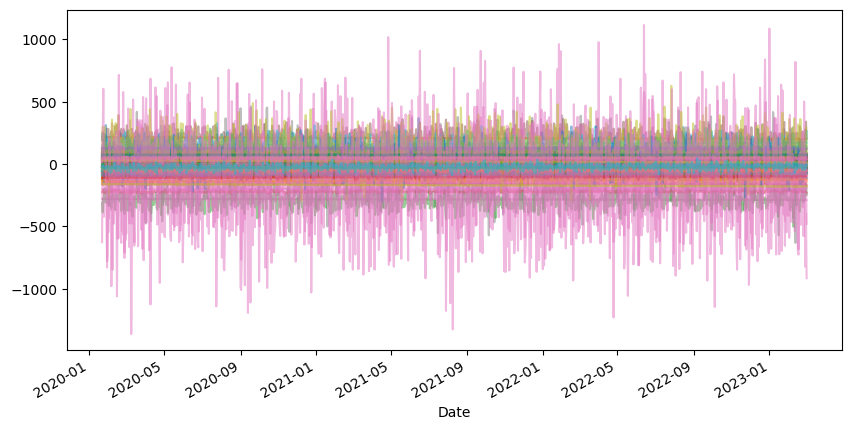

In [5]:
tfd = tfp.distributions
root = tfd.JointDistributionCoroutine.Root

@tfd.JointDistributionCoroutine
def ts_regression_model():
    intercept = yield root(tfd.Normal(0., 100., name="intercept"))
    trend_coeff = yield root(tfd.Normal(0., 10., name="trend_coeff"))
    seasonality_coeff = yield root(
        tfd.Sample(tfd.Normal(0., 1.),
                   sample_shape=seasonality.shape[-1],
                   name="seasonality_coeff"))
    
    noise = yield root(tfd.HalfCauchy(loc=0., scale=5., name="noise_sigma"))
    
    y_hat = (intercept[..., None] +
             tf.einsum("ij,...->...i", trend, trend_coeff) +  # Trend effect
             tf.einsum("ij,...j->...i", seasonality, seasonality_coeff))  # Seasonality effect
    
    yield tfd.Independent(
        tfd.Normal(y_hat, noise[..., None]),
        reinterpreted_batch_ndims=1,
        name="observed"
    )

model_instance = ts_regression_model

prior_samples = model_instance.sample(100)
prior_predictive_timeseries = prior_samples[-1] 

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(florida_data.index[:-num_forecast_steps],
        tf.transpose(prior_predictive_timeseries), alpha=0.5)
ax.set_xlabel("Date")
fig.autofmt_xdate()
plt.show()


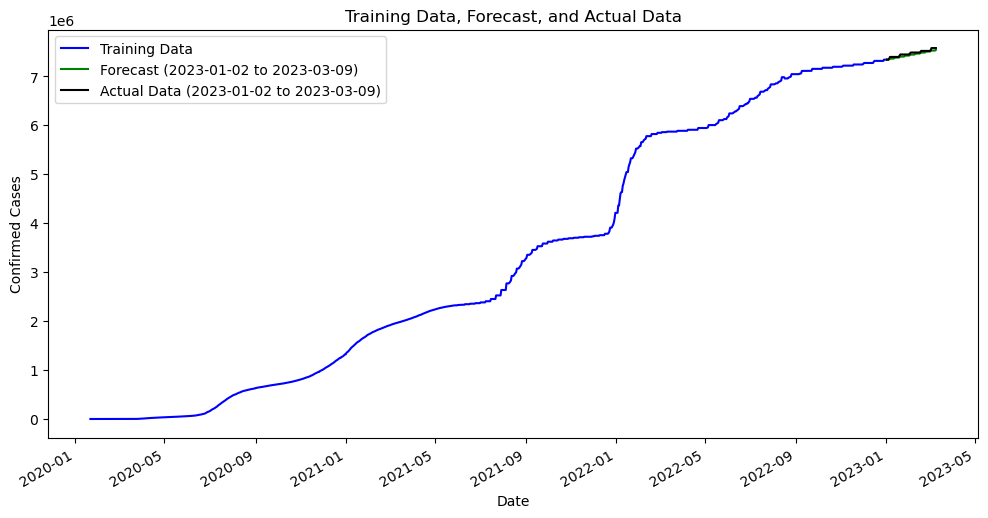

In [6]:
tfd = tfp.distributions
sts = tfp.sts

# Define the date ranges for training and testing
train_end_date = '2023-01-01'
test_start_date = '2023-01-02'
test_end_date = '2023-03-09'

# Training Data (up to 2023-01-01)
florida_training_data = florida_data.loc[:train_end_date, 'Confirmed'].values.astype(np.float32)
dates_train = florida_data.loc[:train_end_date].index

# Testing Data (2023-01-02 to 2023-03-09)
florida_testing_data = florida_data.loc[test_start_date:test_end_date, 'Confirmed'].values.astype(np.float32)
dates_test = florida_data.loc[test_start_date:test_end_date].index

# Define the model with Local Linear Trend and Seasonal components
model = sts.Sum(
    components=[
        sts.LocalLinearTrend(observed_time_series=florida_training_data),
        sts.Seasonal(num_seasons=7, observed_time_series=florida_training_data)  # Weekly seasonality
    ],
    observed_time_series=florida_training_data
)

# Variational Surrogate Posterior
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model)

# Define the log probability function using the updated joint_distribution method
target_log_prob_fn = model.joint_distribution(observed_time_series=florida_training_data).log_prob

# Optimize the variational surrogate posterior
optimizer = tf.optimizers.Adam(learning_rate=0.1)
tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=target_log_prob_fn,
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=200
)

# Forecasting steps from 2023-01-02 to 2023-03-09
num_forecast_steps = len(pd.date_range(start=test_start_date, end=test_end_date, freq="D"))
forecast_dist = tfp.sts.forecast(
    model=model,
    observed_time_series=florida_training_data,
    parameter_samples=variational_posteriors.sample(50),
    num_steps_forecast=num_forecast_steps
)

forecast_mean = forecast_dist.mean().numpy().squeeze()
forecast_index = pd.date_range(start=test_start_date, periods=num_forecast_steps, freq="D")

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot training data up to 2023-01-01
ax.plot(dates_train, florida_training_data, label="Training Data", color="blue")

# Plot forecast mean from 2023-01-02 to 2023-03-09
ax.plot(forecast_index, forecast_mean, label="Forecast (2023-01-02 to 2023-03-09)", color="green")

# Plot actual testing data from 2023-01-02 to 2023-03-09
ax.plot(dates_test, florida_testing_data, label="Actual Data (2023-01-02 to 2023-03-09)", color="black")

# Configure plot settings
ax.set_xlabel("Date")
ax.set_ylabel("Confirmed Cases")
ax.set_title("Training Data, Forecast, and Actual Data")
ax.legend(loc="upper left")

fig.autofmt_xdate()
plt.show()


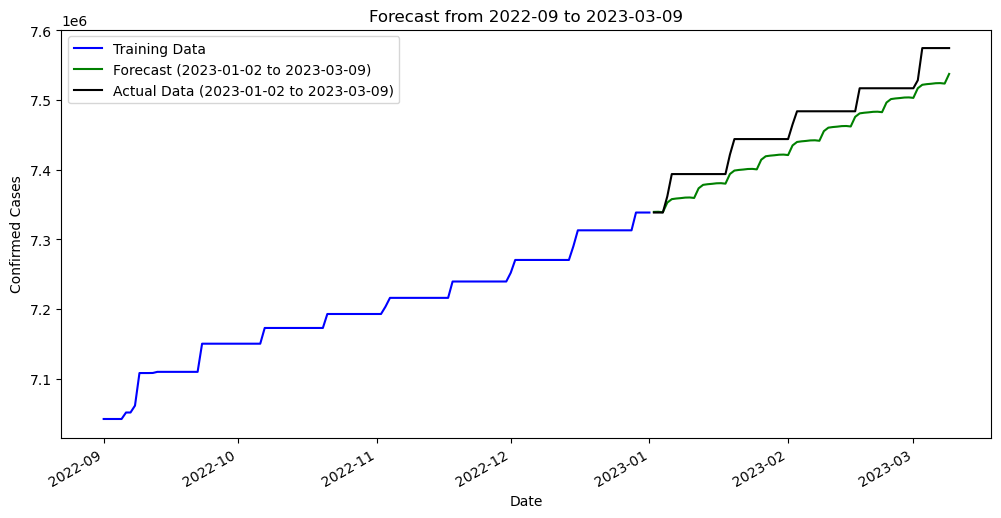

In [7]:
plot_start_date = '2022-09-01'

zoomed_dates_train = florida_data.loc[plot_start_date:train_end_date].index
zoomed_training_data = florida_data.loc[plot_start_date:train_end_date, 'Confirmed'].values.astype(np.float32)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(zoomed_dates_train, zoomed_training_data, label="Training Data", color="blue")
ax.plot(forecast_index, forecast_mean, label="Forecast (2023-01-02 to 2023-03-09)", color="green")
ax.plot(dates_test, florida_testing_data, label="Actual Data (2023-01-02 to 2023-03-09)", color="black")

ax.set_xlabel("Date")
ax.set_ylabel("Confirmed Cases")
ax.set_title("Forecast from 2022-09 to 2023-03-09")
ax.legend(loc="upper left")

fig.autofmt_xdate()
plt.show()


In [8]:
# Calculate RMSE (Root Mean Squared Error)
rmse = ((florida_testing_data - forecast_mean) ** 2).mean() ** 0.5
print("RMSE:", rmse)


RMSE: 31599.05517574853


In [9]:
# Calculate hold-out MAPE (Mean Absolute Percentage Error)
mape = (abs((florida_testing_data - forecast_mean) / florida_testing_data)).mean() * 100
print("MAPE:", mape)


MAPE: 0.3802892053499818
